In [1]:
import argparse
import json
from os import path

from utils import *
from dataloaders import dataloader_factory
from scheduler.utils import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [117]:
DEVICE = 'cuda'
MODEL = 'gru4rec'

type_list = ["base_2022", "base_2021", "partial_2000", "partial_2001", "t_dvae", "s_ed", "s_ep", "s_dvae", "soft"]

suffix = ["base_2022", "base_2021", "base_partial_2022", "base_partial_2022", "dvae", "ed", "ep", "dvae", "soft"]

model_base_path = ["___el_" + s for s in suffix]
primary_keywords = ["gru4rec", "gru4rec", "gru4rec-rate-0.8-seed-2000", "gru4rec-rate-0.8-seed-2001", "gru4rec", "gru4rec", "gru4rec", "gru4rec", "gru4rec"]
secondary_keywords = ["gru4rec", "gru4rec", "gru4rec", "gru4rec", "teacher", "student", "student", "student", "student"]

def dir_finder(path: Path, keyword):
    for child in path.iterdir():
        if child.is_dir() and keyword in child.name:
            yield child

model_path_dict = {}
config_path_dict = {}

rt = Path(".")

for type_, base_path, primary_key, secondary_key in zip(type_list, model_base_path, primary_keywords, secondary_keywords):
    base = rt.joinpath(base_path)
    primary_path = next(dir_finder(base, primary_key))
    secondary_path = next(dir_finder(primary_path, secondary_key))
    secondary_p = secondary_path.joinpath('checkpoint', 'best_acc_model.pth') # model path
    if not secondary_p.exists():
        raise FileNotFoundError(secondary_p)
    model_path_dict[type_] = secondary_p
    
    config_path = primary_path.joinpath('config.json')
    if not config_path.exists():
        raise FileNotFoundError(config_path)
    
    config_path_dict[type_] = config_path

def get_args(tp):
    with open(path.normpath(config_path_dict[tp ]), 'r') as f:
        args = argparse.Namespace()
        args.__dict__.update(json.load(f))
        if args.kwargs is not None:
            args.__dict__.update(args.kwargs)

    args.do_sampling = False
    
    return args

base_args = get_args('base_2022')

In [3]:
train_loader, val_loader, test_loader, dataset = dataloader_factory(base_args)

item_train, item_valid, item_test, usernum, itemnum, rating_train, rating_valid, rating_test = dataset

In [4]:
def get_model_with_weight(model_path, args):
    model = generate_model(args, MODEL, dataset, DEVICE)
    load_state_from_given_path(model, model_path, DEVICE, must_exist=True)
    
    return model
def get_teacher_model(tp='base', use_T=True):
    from models.Ensembler import Ensembler

    if tp in ["base", "dvae"]:
        model = get_model_with_weight(model_path_dict['base_2022'] if tp == 'base' else model_path_dict['t_dvae'], base_args)
        if use_T:
            model.set_temperature(3.0)
    else:
        if tp == 'ed':
            model1 = get_model_with_weight(model_path_dict['base_2021'], base_args)
            model2 = get_model_with_weight(model_path_dict['base_2022'], base_args)

            ed_args = get_args('s_ed')

            T = ed_args.T
        elif tp == 'ep':
            model1 = get_model_with_weight(model_path_dict['partial_2000'], base_args)
            model2 = get_model_with_weight(model_path_dict['partial_2001'], base_args)

            ep_args = get_args('s_ep')

            T = ep_args.T
        
        if use_T:
            model = Ensembler(DEVICE, [model1, model2], temp=T)
        else:
            model = Ensembler(DEVICE, [model1, model2])
        
    return model

def get_student_model(tp='base'):
    return get_model_with_weight(model_path=model_path_dict[tp], args=base_args)

In [5]:
bs = get_teacher_model('base')
ed = get_teacher_model('ed')
ep = get_teacher_model('ep')
dvae = get_teacher_model('dvae')

s_ed = get_student_model('s_ed')
s_ep = get_student_model('s_ep')
s_dvae = get_student_model('s_dvae')

In [118]:
soft = get_student_model('soft')

In [6]:
def get_good_users(model, verbose=False): # rating = 1, and HIT at top 1
    model.eval()

    iterator = tqdm(test_loader) if verbose else test_loader
    good_users = set()
    for batch in iterator:
        if DEVICE == 'cuda':
            batch = [x.to('cuda') for x in batch]
        seqs = batch[0]
        answer = batch[1]
        ratings = batch[2]
        users = batch[4]

        # get labels, scores and ratings
        batch_size = len(seqs)
        # labels = torch.zeros(batch_size, itemnum + 1, device=DEVICE)
        with torch.no_grad():
            scores = model.full_sort_predict(batch)

        row, col = [], []

        for i in range(batch_size):
            seq = list(set(seqs[i].tolist()) | set(answer[i].tolist()))
            seq.remove(answer[i][0].item())
            if itemnum + 1 in seq:
                seq.remove(itemnum + 1)
            row += [i] * len(seq)
            col += seq
            # labels[i][answer[i]] = 1
        scores[row, col] = -1e9

        ratings.squeeze_()
        scores = scores[ratings == 1.]
        labels = answer[ratings == 1.].squeeze()
        users = users[ratings == 1.].squeeze()

        scores: torch.Tensor
        top1_items = scores.argmax(dim=1)

        # print(top1_items.size(), labels.size())

        good_users |= set(users[top1_items == labels].tolist())

    return good_users

In [7]:
users_ed = get_good_users(s_ed, verbose=True)
users_ep = get_good_users(s_ep, verbose=True)
users_dvae = get_good_users(s_dvae, verbose=True)

users = users_ed | users_ep | users_dvae

100%|██████████| 400/400 [00:30<00:00, 13.09it/s]


In [8]:
from collections import Counter

In [9]:
popularity = Counter()
for user in range(0, usernum):
    popularity.update(item_train[user])
    popularity.update(item_valid[user])
    popularity.update(item_test[user])

In [48]:
pop_model = POPModel(None, dataset, 'cpu', 10, 3)

In [41]:
pop_items = [x for (x, _) in sorted(popularity.items(), key=lambda x: -x[1])]

In [46]:
from models.pop import POPModel

In [81]:
pop_100 = pop_items[:5000]
pop_100 = torch.Tensor(pop_100).to(int).view(1, -1)

In [82]:
rnd_user = np.random.choice(list(users))
# get item seq

picked = test_loader.dataset.__getitem__(rnd_user)
picked = [x.unsqueeze(0) for x in picked]

with torch.no_grad():
    bs_score = bs.full_sort_predict(picked).softmax(dim=1)
    ed_score = ed.full_sort_predict(picked)
    ep_score = ep.full_sort_predict(picked)
    dvae_score = dvae.full_sort_predict(picked).softmax(dim=1)
    pop_s = pop_model.full_sort_predict(picked).gather(dim=-1, index=pop_100).softmax(dim=1)

bs_s = bs_score.gather(dim=-1, index=pop_100)
ed_s = ed_score.gather(dim=-1, index=pop_100)
ep_s = ep_score.gather(dim=-1, index=pop_100)
dvae_s = dvae_score.gather(dim=-1, index=pop_100)

# bs_s, dvae_s, pop_s = [torch.softmax(x, dim=1) for x in [bs_s, dvae_s, pop_s]]

In [103]:
def moving_average(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, 'valid')  # numpy的卷积函数

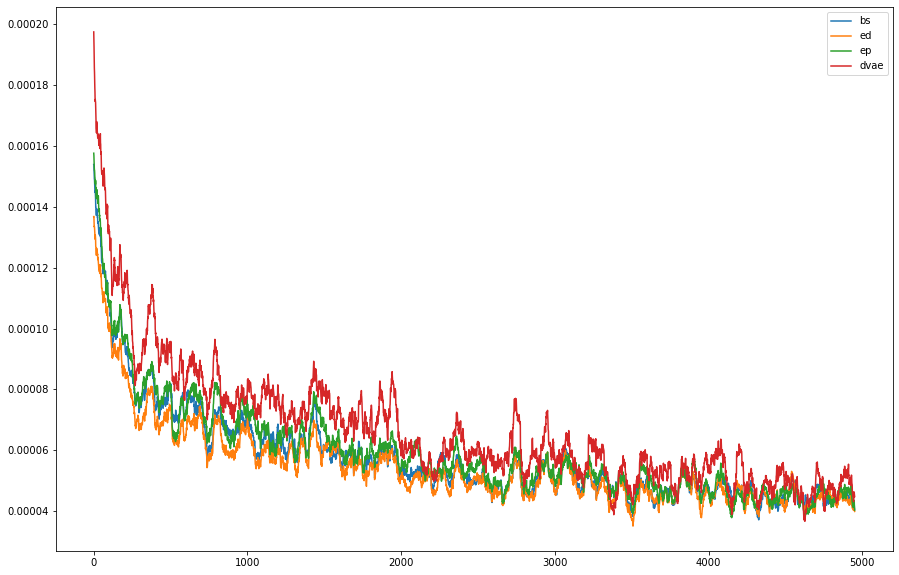

In [108]:
plt.figure(figsize=(15, 10))
for s in [bs_s, ed_s, ep_s, dvae_s]:
    # plt.plot(s.squeeze(), alpha=0.05)
    arr = s.squeeze().tolist()
    plt.plot(moving_average(arr, 50))
plt.legend(labels=["bs", "ed", "ep", "dvae"])

In [114]:

pop = [0] * (itemnum + 1)

for i, v in popularity.items():
    pop[i] = v
item_inter = torch.tensor(pop).to(torch.float)

def _calculate_ARP(batch, model):
    seqs = batch[0]
    answer = batch[1]
    ratings = batch[2]
    
    batch = [x.to(DEVICE) for x in batch]

    batch_size = len(seqs)
    with torch.no_grad():
        scores = model.full_sort_predict(batch)

    row = []
    col = []

    for i in range(batch_size):
        seq = list(set(seqs[i].tolist()) | set(answer[i].tolist()))
        seq.remove(answer[i][0].item())
        if itemnum + 1 in seq:
            seq.remove(itemnum + 1)
        row += [i] * len(seq)
        col += seq
    scores[row, col] = -1e9

    scores = scores[ratings.squeeze() == 1.]

    rank = (-scores).argsort(dim=1)[:, :10]

    return  item_inter[rank].mean()

def calculate_ARP(tag: str, model):
    model.eval()

    rate = 0.
    t = 1
    tq = tqdm(test_loader)

    for batch in tq:
        rate += _calculate_ARP(batch, model)

        tq.set_description(f"tag: {tag}, rate: {rate / t}")

        t += 1

    rate /= len(test_loader)

    print(tag, ":", rate.item())

In [115]:
calculate_ARP('base', bs)

tag: base, rate: 1149.6385498046875: 100%|██████████| 400/400 [04:30<00:00,  1.48it/s]

base : 1149.6385498046875


In [119]:
DEVICE = 'cuda'

In [116]:
DEVICE = 'cuda'
s_ed.to(DEVICE)
s_ep.to(DEVICE)
s_dvae.to(DEVICE)

calculate_ARP('ed', s_ed)
calculate_ARP('ep', s_ep)
calculate_ARP('dvae', s_dvae)

tag: ed, rate: 744.892333984375: 100%|██████████| 400/400 [00:17<00:00, 23.45it/s] 


ed : 744.892333984375


tag: ep, rate: 702.2991333007812: 100%|██████████| 400/400 [00:16<00:00, 23.59it/s]


ep : 702.2991333007812


tag: dvae, rate: 745.7974243164062: 100%|██████████| 400/400 [00:16<00:00, 24.05it/s]

dvae : 745.7974243164062


In [120]:
soft.to(DEVICE)
calculate_ARP('soft', soft)

tag: soft, rate: 732.640380859375: 100%|██████████| 400/400 [00:16<00:00, 23.77it/s] 

soft : 732.640380859375
